<a id="1.Summary"></a>
# 1.Summary

- https://www.kaggle.com/c/google-quest-challenge
- BERT https://zhuanlan.zhihu.com/p/269516862

- 1.EDA
- 2.Preprocess data
- 3.Classify
- 4.

Typically, we have a Q&A dataset and there are 30+ columns `[0,1]` data coming from human evaluation.

<a id="2.Table of Contents"></a>
# 2.Tabole of Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Import Packages">Import Packages</a></li>
    <li><a href="#4.Preprocess">Preprocess</a></li>
    <ul>
       <li><a href="#4.1 Import Data">4.1 Import Data</a></li>
       <li><a href="#4.2 Clean Data">4.2 Clean Data</a></li> 
       <li><a href="#4.3 Tokenize">4.3 Tokenize</a></li> 
       <li><a href="#4.4 Label Processing">4.4 Label Processing</a></li>  
       <li><a href="#4.5 Glove Vector">4.4 Label Processing</a></li>  
    </ul>
    <li><a href="#5.EDA">EDA</a></li>
    <li><a href="#6.Multi-Tokenize">Multi-Tokenize</a></li>
    <ul>
       <li><a href="#TFIDF">6.1 TFIDF</a></li>
    </ul>
    <li><a href="#7.Classify">Classify</a></li>
    <li><a href="#8.Models">Models</a></li>
    <ul>
       <li><a href="#8.5 Seq2Seq">8.5 Seq2Seq</a></li>
    </ul>
    <li><a href="#9.Main Function">Main Function</a></li>
    <li><a href="#10.Unused Code">Unused Code</a></li>
</ol>

<br>

<a id="3.Import Packages"></a>
# 3.Import Packages
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [3]:
# most of data we will store in 
import pandas as pd
import numpy as np

# use regex to extract text
import re
# using copy to duplicate
import copy
# recording each step runing time
import time
# corpus will be string format
import string
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns

# the easiest way to get text is using bs4 to get only text
from bs4 import BeautifulSoup
#cacualte spearmen correcltion 
from scipy import stats
# diplay image for demonstration
from IPython.display import Image



# one of tokenize method
from sklearn.feature_extraction.text import TfidfVectorizer
# split data with random seed (37)
from sklearn.model_selection import train_test_split

# at EDA get Tokenizer info for deciding hyperparameters
from tensorflow.keras.preprocessing.text import Tokenizer
# add padding to a tokenized sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# input all the layers we might use 
from tensorflow.keras.layers import (Embedding, Dense, Conv1D, MaxPooling1D,
Dropout, Activation, Input, Flatten, Concatenate, LSTM, GlobalAveragePooling1D)
# do not use sequential to build model
from tensorflow.keras import Model
# need specify lr in optiizer
from tensorflow.keras import optimizers
# use categorical to transform to one-hot coding
from tensorflow.keras.utils import to_categorical

import tensorflow as tf

<br>

<a id="4.Preprocess"></a>
# 4.Preprocess
<a href="#2.Table of Contents">Click this Link back to Top</a>

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix <code>question_</code> relate to the <code>question_title</code> and/or <code>question_body</code> features in the data. Target labels with the prefix <code>answer_</code> relate to the <code>answer</code> feature.

<a id="4.1 Import Data"></a>
### 4.1 Import Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [21]:
class PreprocessData(object):
    """
    Because this data have two components, so we first preprocess it and then return raw and corpus to do EDA
    We also need to use preprocee to estimate hyperparameters
    """
    def __init__(self):
        None
    
    def import_data(self,path):
        """
        Arugs:
        ------
        path:string
            directory of file you want to read
            
        Return:
        ------
        
        
        """
        # read the raw unpreprocess data into df_raw
        df_raw = pd.read_csv(path)
        # first we need extract the X(data) part and y(label) part.
        # In this dataset, columns from "qa_id" to "host" will be X(data)
        # columns from "question_asker_intent_understanding" to "answer_will_written" are human label result which is numerical betwenn [0,1]
        # 
        X_df = df_raw.iloc[:,0:10]
        y_df = df_raw.iloc[:,11:]
        
        # we classify question_title and question_body in X_question_df, question_ related columns into y_question_df, 
        #this is X y for one task
        # we classify answer in X_answer, answer_ related column into y_answer_df. This is X and y for another task
        # maybe we need sometime consider questoin and answer together
        # i believe user info have no contribution with this task
        # construct DataFrame 
        self.X_question_df = df_raw.loc[:,['qa_id', 'question_title', 'question_body','category','host']]
        self.X_answer_df = df_raw.loc[:,['qa_id','answer','category','host']]
        
        # initial label list
        y_question_list = []
        y_answer_list = []
        for idx, i in enumerate(y_df.columns):
            if "question_" in i:
                y_question_list.append(i)
            elif "answer_" in i:
                y_answer_list.append(i)
            else:
                continue
                
        # extract label of question
        self.y_question_df = df_raw[y_question_list]
        self.y_answer_df = df_raw[y_answer_list]
        # So, for now, we have two pair of dataset, firt is (X_question_df + y_question_df). Second is (X_answer_df + y_answer_df)
        
        #for question part, i think we need a new column for merge title and body, but we still reserve seperate column
        self.X_question_df['question'] = self.X_question_df['question_title'] + self.X_question_df['question_body']
        
        return df_raw, self.X_question_df, self.X_answer_df, self.y_question_df, self.y_answer_df

<a id="4.2 Clean Data"></a>
### 4.2 Clean Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [22]:
class CleanData(object):
    def __init__(self):
        """
        """
        None

    def clean_process(self, df, column_1, punctuation_fun = True, stopwords_fun = False):
        """
        I have reserve several interface and options to response different scenarios
        
        steps
        1.lowercase()
        2.remove special puncuation and symbol
        4.remove string puncuation
        5.only reserve words
        6.remove stop words(if we eliminate most frequcen word, do we still this? and did this affect LSTM?) so i put a switch

        Argus:
        -----
        df:DataFrame
            Input come from import_data() [column_1] is the columns that need corpus,
        column_1:string
            the name of column we need clean
        stopwrods_fun:boolen
            True, remove stopwords; False, do not remove stopwords


        Return:
        ------
        courpus_df:DataFrame
            Because we use apply(lambda) to process each cell in DataFrame, so output is still that DataFrame
        """
        print("*"*50,"Start Clean data", "*"*50)
        start_time = time.time()
        #original datatype is serise, first transfrom to string and get lower() case text
        corpus = df[column_1].str.lower()

        # Because we don't have html characters,we don't need this part
        # using bs4 to eliminate html
        #soup = BeautifulSoup(corpus_2, 'lxml')
        #corpus_3 = soup.get_text()
        corpus = corpus.apply(lambda x: self.remove_html(x))
        # any speical punctuation in filter sring should add "\" before it
        # This line is a compensation for remove_pun, if we puncturation_fun==False, which means we want to reserve some meanningfol
        # symbols, we can use this seperate function to remove those meaningless symbols
        corpus = corpus.apply(lambda x: self.remove_regex(x))

        # if punctuation_fun == True, we remove punctuation. 
        #In this step, further we maybe need seperate them to keep question mark for represent some meaning
        if punctuation_fun:
            # use sring.puncutation to eliminate, but we should first remove url. I believe this should be last step
            corpus = corpus.apply(lambda x: self.remove_pun(x))

        # this is last safeguard for clean_data process. This function literally only extract 
        # only reserve words
        pattern=r'[a-zA-Z][-._a-zA-Z]*[a-zA-Z]'
        corpus = [" ".join(re.findall(pattern, x)) for x in corpus]


        if stopwords_fun:
            # remove stop words
            corpus_list = []
            for sentence in tqdm(corpus_6):
                corpus_list.append(self.remove_stopwords(sentence))
    #         corpus_7 = corpus_6.apply(lambda x: remove_stopwords(x))
    #         corpus_7 = [remove_stopwords(x) for x in corpus_6]
            corpus = np.array(corpus_list)
            
#         # ********************improve strategy***************************** 
#         # due to this is very small, perhaps add stem and lemmanization will be better
#         # According to Pro Liu, this step is not necessary
#         # ********************improve strategy***************************** 
        
        
        #we sitll need to manipulate with index because it contain important relationship between corpus and claasify
        #list to pd.Series
#         corpus_8 = pd.Series(np.array(corpus))
        df['cleaned'] = pd.Series(np.array(corpus))

        cost_time = round((time.time()- start_time),4)
        print("*"*40,"End clean_data() with {} second".format(cost_time), "*"*40, end='\n\n')
        


        return df

    def remove_pun(self, text):
        """
        The reason i use seperate function is that pandas.apply can manipulate with column value. 
        If we use loop directly, we will get a join corpus without paragraph structure
        """
        no_pun = "".join([c for c in text if c not in string.punctuation])
        return no_pun

    def remove_html(self, text):
        """
        Use bs4 to extract text
        """
        soup = BeautifulSoup(text, 'lxml')
        no_html = soup.get_text()
        return no_html

    def remove_regex(self, text):
        """
        It was designed to remove special punctuation and character which we can't manipulate with string.puncutation effectively
        #             #!"#$%&()*\+,-./:;<=>\?@\[\\\]^_`{|}~\\t\\n\\r\“
        """
        #remove url
        no_reg = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
        #remove numbers
        no_reg = re.sub('\w*\d\w*', '', no_reg)
        return no_reg

    def remove_stopwords(self, sentence):
        stop_words_set = set(stopwords.words("english"))
        no_stopwords = " ".join([word for word in sentence.split(" ") if not word in stop_words_set])
    #     for word in text:
    #         if word not in stopwords.words("english"):
    #             output = output + " " + word
        return no_stopwords

<a id="4.3 Tokenize"></a>
### 4.3 Tokenize
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [129]:
class TokenizeData(object):
    """
    Tokenize is only split sent
    """
    def __init__(self):
        """
        """
        # using distribution to decide this parameters
        self.MAX_Q_SEQ_LEN = 400
        self.MAX_A_SEQ_LEN = 1000
        
        
    def tokenize_plot(self, question_cleaned_df, answer_cleaned_df):
        """
        decide how many words should be left for tokenzie() function
        """
        # do not set num_words at first time and to see how many unique words we have 
        tokenizer_model = Tokenizer(split=' ', char_level=False, oov_token="<OOV>")
        # here is another trick, we need consider question and answer courpus into one unit
        # so we build a new big combination corpus,
        corpus_sum = question_cleaned_df['cleaned'] + answer_cleaned_df['cleaned']
        # use previous model to fit this large combination corpus
        tokenizer_model.fit_on_texts(corpus_sum)
        # get the word_index and word_count dictionary
        # word_index is the number corresponding to words by frequence. word_count is the sepcific words appeart times frequency
        word_index, word_count = tokenizer_model.word_index, tokenizer_model.word_counts
        print(f"we got unique {len(word_index)} words")
        MAX_WORD=0
        for i in word_count.values():
            if i>5:
                MAX_WORD+=1
        print(f"we have {MAX_WORD} words appear more than 5 times")
        
                               
        #**************new tokenize process******************
        # due to bad performance, i remain all sentence and all word in this small dataset
        MAX_WORD = 72070
        # start a new standard processs from begining
        tokenizer_new = Tokenizer(num_words = MAX_WORD, split=' ', char_level=False, oov_token="<OOV>")
        # fit on combination corpus(question+answer). We can't just use one component to build tokenizer
        tokenizer_new.fit_on_texts(corpus_sum)
        # get new word_index and index_word. we use index_word(index:word) to restore orignial sentence by numerical sequence
        self.word_index, self.index_word = tokenizer_new.word_index, tokenizer_new.index_word
        # get question of sequence
        question_seq = tokenizer_new.texts_to_sequences(question_cleaned_df['cleaned'])
        # get sequence of answer
        answer_seq= tokenizer_new.texts_to_sequences(answer_cleaned_df['cleaned'])
        # get padded
        self.question_padded = pad_sequences(question_seq, padding='post', maxlen=self.MAX_Q_SEQ_LEN, truncating='post')
        # using padded
        self.answer_padded = pad_sequences(answer_seq, padding='post', maxlen=self.MAX_A_SEQ_LEN, truncating='post')
        #**************new tokenize process******************
        question_cleaned_df['padded'] = list(self.question_padded)
        
        return self.question_padded, question_cleaned_df,self.answer_padded, self.word_index, self.index_word
    
    
    def sequence_to_text(self):
        """
        Use this function to convert padded sequnce back to text according to word_index
        """
        # create a empty list
        word_list = []
        for idx, i in enumerate(self.question_padded):
            # for every word in self.question_padded[0]=sentence, put it into a list
            words = np.array([index_word.get(word) for word in i])
            # insert into list
            word_list.append(words)
        # create a dictionary to build DataFrame
        dic = {"sequence_to_text": word_list}
        word_df = pd.DataFrame(dic)
        return word_df
    
    
    def label_feature(self, y_question_df, y_answer_df):


In [52]:
token_class = TokenizeData()
y_q_label_df, y_a_label_df = token_class.label_feature( y_question_df, y_answer_df)

<a id="4.4 Label Processing"></a>
### 4.4 Label Processing
<a href="#2.Table of Contents">Click this Link back to Top</a>

According to my experimental process. If we just use numerical result to get spearman score, the result is not significance. Although we can get a not that bad score, but the result is not much intuitive. So, afther eda the label numericla, we find it not continuous, its a set of discrete numbers. We can segement lablel result into 10 part and transfer it into a classification proble. rather than using numerical result to predict contiunous label.

In [351]:
class LabelProcess(object):
    """
    
    """
    def __init__(self, y_question_df, y_answer_df):
        self.y_question_df = y_question_df
        self.y_answer_df = y_answer_df
    
    def num_label(self):
        """
        In future, i will use arguritem to filter column. For now, i do it manually
        As i test use pure numerical algorithem to calcualte 
        
        """
        # first try these labels
        feature_col_q = ['question_asker_intent_understanding',
                       'question_body_critical',
                       'question_expect_short_answer',
                       'question_interestingness_others'
                      ]
        y_q_label_df = self.y_question_df[feature_col_q]
        
        #extract the answer label features
        feature_col_a = ['answer_type_instructions']
        y_a_label_df = self.y_answer_df[feature_col_a]
        
        return y_q_label_df, y_a_label_df
    
    
    def auto_classify(self):
        """
        This result maybe get better result but not palusible. 
        Because we don't konw how this data collect and why they got this pattern result
        So we can not make sure new data will still classify like 0.5 0.633
        
        input will be a column of label feature and output will be a 10 dimension to_categrical matrix
        """
        y_q_label_df = to_categorical(self.y_question_df.iloc[:,0], num_classes=4)
        y_a_label_df = to_categorical(self.y_answer_df.iloc[:,0], num_classes=5)
        
        return y_q_label_df, y_a_label_df
    
    def manual_calssify(self, label_col):
        """
        This function will manually segement numerical 
        """
        # initial empty matrix
        categorical = np.zeros((len(label_col), 10), dtype='float32')
        for idx, label in enumerate(label_col):
            if 0 <= label < 0.1:
                categorical[idx, 0] = 1
            elif 0.1 <= label < 0.2:
                categorical[idx, 1] = 1
            elif 0.2 <= label < 0.3:
                categorical[idx, 2] = 1
            elif 0.3 <= label < 0.4:
                categorical[idx, 3] = 1
            elif 0.4 <= label < 0.5:
                categorical[idx, 4] = 1     
            elif 0.5 <= label < 0.6:
                categorical[idx, 5] = 1
            elif 0.6 <= label < 0.7:
                categorical[idx, 6] = 1
            elif 0.7 <= label < 0.8:
                categorical[idx, 7] = 1
            elif 0.8 <= label < 0.9:
                categorical[idx, 8] = 1
            elif 0.9 <= label <= 1.0:
                categorical[idx, 9] = 1
            else:
                print('ERROR', label)
                
        # test part, if our calcuatlion is correct, all row should be included and have exactly number one
        # If correct, nothing happen, if condition return false, AssertionError is raised
        assert np.sum(categorical, axis=1).sum() == len(label_col)
#         (unique, counts) = np.unique(test_13, return_counts=True)
        return categorical
                
        """
        # convert input dimension into np.array int format
        y = np.array(y, dtype='int')
        # get input_shape of y. Be caution, we accept high dimension narray as input
        input_shape = y.shape
        # if input_shape is exist, and last dimension is 1 and dimension of input_shape more than 2, then we only need the non-one part
        # for exmaple, if intput dimension last number is 1, then we think the use dimension is not include this one.
        # the final input_shape will only be dimesion from number to second to last (3,3,1) -> (3,3)
        if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
            input_shape = tuple(input_shape[:-1])
        # flattern the y into contiguous array
        y = y.ravel()
        # if we don't specifity assign the classification number, the number of class of will max of y blus one 
        if not num_classes:
            num_classes = np.max(y) + 1
        # n is the number of examples
        n = y.shape[0]
        # create an empty matrix with (n,classes) dimension, n is number of exmaple,
        categorical = np.zeros((n, num_classes), dtype=dtype)
        #
        categorical[np.arange(n), y] = 1
        output_shape = input_shape + (num_classes,)
        categorical = np.reshape(categorical, output_shape)
        return categorical
        """

In [343]:
lab_class = LabelProcess(y_question_df, y_answer_df)
# y_q_label_df, y_a_label_df = lab_class.classify_label()
y_a_label_np = lab_class.manual_calssify(y_answer_df.iloc[:,0])
y_a_label_np.shape

(6079, 10)

In [335]:
y_answer_df.iloc[:,0]

0       1.000000
1       0.888889
2       0.777778
3       0.833333
4       1.000000
          ...   
6074    1.000000
6075    0.888889
6076    0.888889
6077    0.888889
6078    0.888889
Name: answer_helpful, Length: 6079, dtype: float64

In [336]:
test_13


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [337]:
np.sum(test_13, axis=1)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [338]:
(unique, counts) = np.unique(test_13, return_counts=True)

In [339]:
unique

array([0., 1.], dtype=float32)

In [340]:
counts

array([54711,  6079], dtype=int64)

In [341]:
y_answer_df.iloc[:,0].value_counts()

1.000000    3701
0.888889    1223
0.666667     431
0.777778     427
0.833333     219
0.555556      26
0.333333      25
0.444444      14
0.500000      13
Name: answer_helpful, dtype: int64

In [257]:
y_q_label_df = to_categorical(y_question_df, num_classes=4)

In [258]:
y_q_label_df.shape

(6079, 21, 4)

In [275]:
y = y_question_df

In [281]:
y

array([1, 0, 0, ..., 1, 0, 1])

In [278]:
input_shape = y.shape

In [279]:
input_shape

(6079, 21)

In [252]:
num_classes = 10

In [240]:
input_shape = np.zeros((3,3,1)).shape

In [241]:
input_shape

(3, 3, 1)

In [242]:
if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
    print(input_shape)

(3, 3)


In [280]:
y = np.array(y, dtype='int')
y = y.ravel()
n = y.shape[0]
categorical = np.zeros((n, num_classes), dtype='float32')
# categorical[np.arange(n), y] = 1

In [266]:
type(categorical)

numpy.ndarray

In [269]:
y.shape

(127659,)

In [267]:
categorical.shape

(127659, 10)

In [274]:
categorical[6079, y] = 1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [262]:
output_shape = input_shape + (num_classes,)
output_shape

(6079, 9, 10)

In [214]:
y_question_df

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written
0,1.000000,0.333333,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,1.000000
1,1.000000,1.000000,0.000000,0.500000,1.000000,1.0,0.444444,0.444444,0.666667,0.0,...,0.666667,0.666667,0.0,0.333333,0.0,0.000000,0.000000,0.333333,0.0,0.888889
2,0.888889,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.444444,0.333333,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.333333,0.333333,0.0,0.777778
3,0.888889,0.666667,0.666667,1.000000,1.000000,1.0,0.444444,0.444444,0.000000,0.0,...,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.888889
4,1.000000,0.666667,0.000000,1.000000,1.000000,1.0,0.666667,0.666667,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,1.000000,0.777778,0.000000,1.000000,1.000000,1.0,0.888889,0.888889,0.333333,0.0,...,0.333333,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.666667,0.0,0.777778
6075,1.000000,0.777778,0.000000,1.000000,0.666667,0.5,0.777778,0.777778,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.666667,0.666667,0.000000,0.0,0.777778
6076,0.888889,0.555556,0.000000,0.666667,0.333333,1.0,0.444444,0.333333,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.444444
6077,1.000000,0.444444,0.333333,0.000000,0.000000,0.0,0.777778,0.555556,1.000000,0.0,...,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.333333,0.666667,0.0,1.000000


In [184]:
y_a_label_df.shape

(6079, 5)

In [192]:
y_a_label_df[2]

array([1., 0., 0., 0., 0.], dtype=float32)

In [190]:
y_answer_df.head(2)

,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [188]:
y_answer_df.iloc[:,0]

0       1.000000
1       0.888889
2       0.777778
3       0.833333
4       1.000000
          ...   
6074    1.000000
6075    0.888889
6076    0.888889
6077    0.888889
6078    0.888889
Name: answer_helpful, Length: 6079, dtype: float64

In [181]:
y_answer_df.iloc[:,0].value_counts()

1.000000    3701
0.888889    1223
0.666667     431
0.777778     427
0.833333     219
0.555556      26
0.333333      25
0.444444      14
0.500000      13
Name: answer_helpful, dtype: int64

In [56]:
answer_cleaned_df['cleaned']

0       just got extension tubes so heres the skinny w...
1       it might be helpful to look into the definitio...
2       do you even need grooves we make several produ...
3       sending an affidavit it is dispute between ras...
4       check out image trace in adobe illustrator lik...
                              ...                        
6074    if youre thinking about wearing ski helmet for...
6075    you can replace the pads as stated elsewhere t...
6076    maybe help if can be fixes origin of this erro...
6077    as nonmathematician am somewhat mystified by t...
6078    first really like erics answer for practical r...
Name: cleaned, Length: 6079, dtype: object

95%th percentile of cleaned sentence lenght is 2130.199999999999
90%th percentile of sentence lenght is 1513.5999999999995
85%th percentile of  sentence lenght is 1219.0


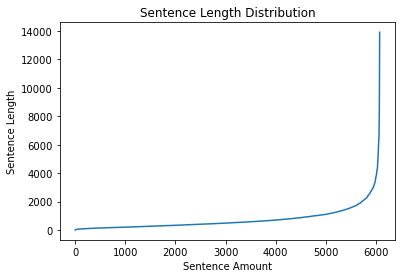

In [64]:
sentence_len = [len(x) for x in answer_cleaned_df['cleaned']]
sentence_len_arr = np.array(sentence_len)
# change the type to numpy array and get 95%/90%/85%th percentile of the data value
print(f"95%th percentile of cleaned sentence lenght is {np.percentile(sentence_len_arr, 95)}")    
print(f"90%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 90)}")
print(f"85%th percentile of  sentence lenght is {np.percentile(sentence_len_arr, 85)}")
sentence_len.sort()
plt.plot(np.arange(len(sentence_len)), sentence_len)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Amount")
plt.ylabel("Sentence Length")
plt.show()

<a id="5.EDA"></a>
# 5.EDA
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [211]:
class EdaData(object):
    """
    explorer this data structure
    """
    def __init__(self):
        """
        """
        # using distribution to decide this parameters
        self.MAX_SEQ_LENGTH = 400
        
    def q_distribution_plot():
        # from the plot we can see
        plt.scatter(y_answer_df.index, y_answer_df.iloc[:,0])
        plt.show()
        
    def question_plot(self, df):
        """
        Due to different column number, we need to 
        """
        #
        fig, axes = plt.subplots(7, 3, figsize=(18, 15))
        axes = axes.ravel()
        bins = np.linspace(0, 1, 20)

        for i, col in enumerate(df.columns):
            ax = axes[i]
            sns.histplot(df[col], label=col, kde=False, bins=bins, ax=ax)
            # ax.set_title(col)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 6079])
        plt.tight_layout()
        plt.show()
        plt.close()
        
    def answer_plot(self, df):
        """
        Due to different column number, we need to 
        """
        #
        fig, axes = plt.subplots(7, 3, figsize=(18, 15))
        axes = axes.ravel()
        bins = np.linspace(0, 1, 20)

        for i, col in enumerate(df.columns):
            ax = axes[i]
            sns.histplot(df[col], label=col, kde=False, bins=bins, ax=ax)
            # ax.set_title(col)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 6079])
        plt.tight_layout()
        plt.show()
        plt.close()
        
        
        
    def eda_length(df):
        """
        use statisc and plot to determine hyperparameters, such as MAX_SEQ_LEN, TOP_WORDS
        Arugs:
        ------

        """
        # get the 'AUTHOR' column sentence length
        sentence_len = [len(x) for x in df[df.columns[0]]]
        sentence_len_arr = np.array(sentence_len)
        # change the type to numpy array and get 95%/90%/85%th percentile of the data value
        print(f"95%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 95)}")
        print(f"90%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 90)}")
        print(f"85%th percentile of {df.columns[0]} sentence lenght is {np.percentile(sentence_len_arr, 85)}")
        # get sorted 
        sentence_len.sort()
        plt.plot(np.arange(len(sentence_len)), sentence_len)
        plt.title("Sentence Length Distribution")
        plt.xlabel("Sentence Amount")
        plt.ylabel("Sentence Length")
        plt.show()
        print(f"For MAX_SEQ_LEN, 1000 words in one sentce will reasonable to preseve 90% sentence and delete outlier value")

        return None

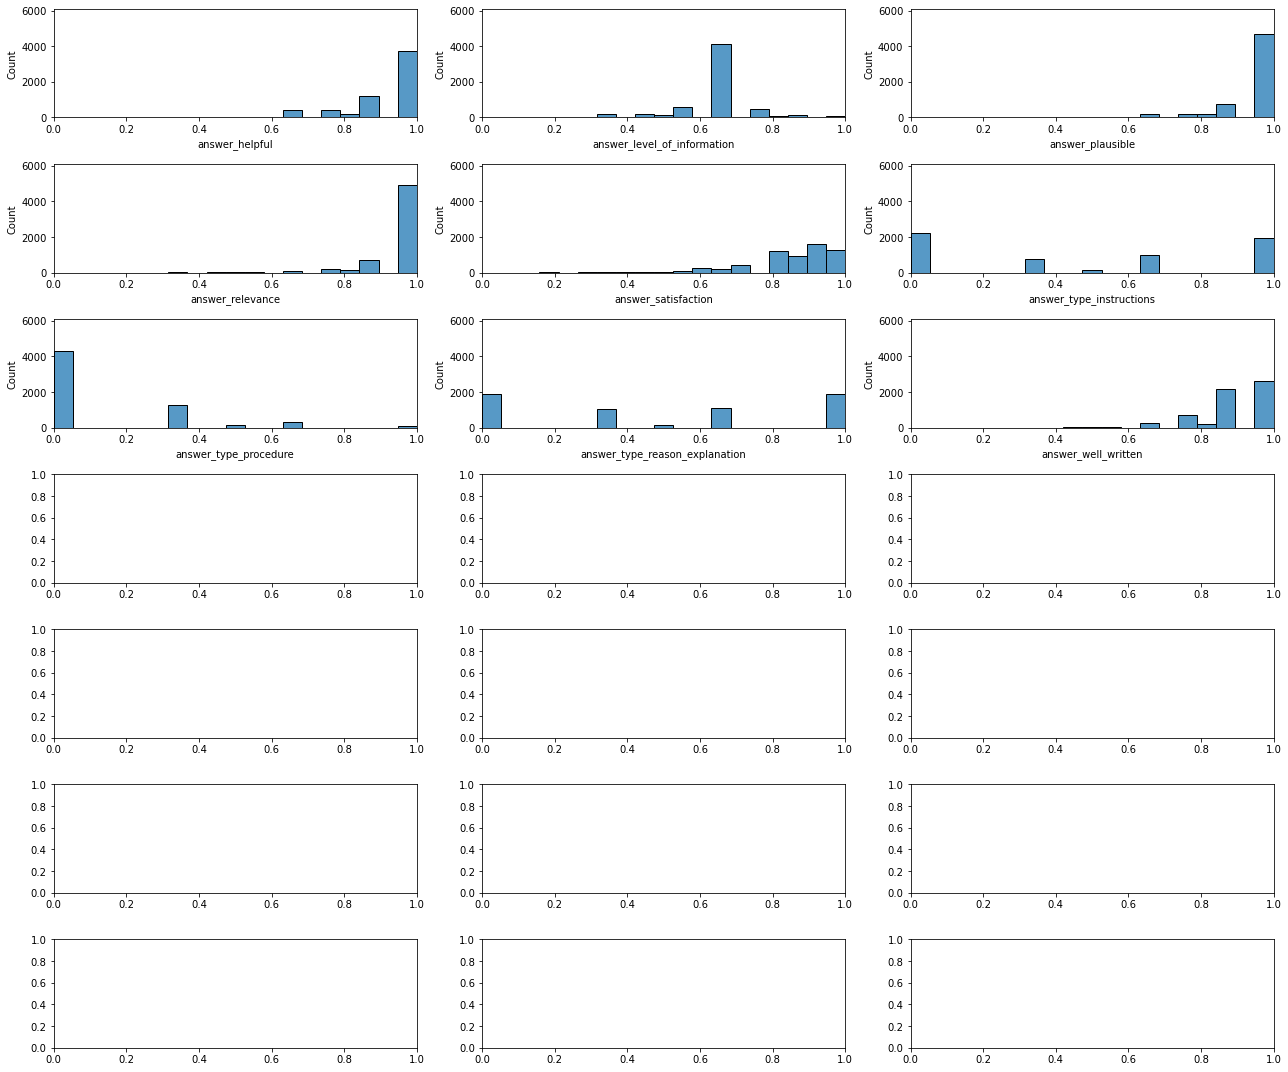

In [195]:
eda_class = EdaData()
eda_class.answer_plot(y_answer_df)

In [119]:
y_answer_df.iloc[:,0]

0       1.000000
1       0.888889
2       0.777778
3       0.833333
4       1.000000
          ...   
6074    1.000000
6075    0.888889
6076    0.888889
6077    0.888889
6078    0.888889
Name: answer_helpful, Length: 6079, dtype: float64

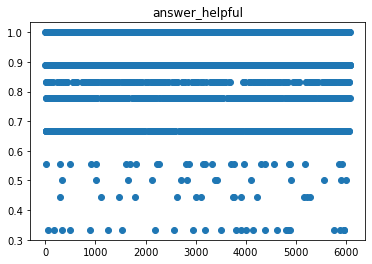

In [152]:
# from the plot we can see
plt.scatter(y_answer_df.index, y_answer_df.iloc[:,0])
plt.title(y_answer_df.columns[0])
plt.show()

In [170]:
data_10 = y_answer_df.iloc[:,1]
data_10.value_counts()

0.666667    4114
0.555556     566
0.777778     482
0.444444     210
0.333333     208
0.500000     161
0.888889     144
0.833333      99
1.000000      95
Name: answer_level_of_information, dtype: int64

In [197]:
b = data_10.value_counts()

In [203]:
b.values

array([4114,  566,  482,  210,  208,  161,  144,   99,   95], dtype=int64)

(array([ 208.,  210.,  161.,  566., 4114.,    0.,  482.,   99.,  144.,
          95.]),
 array([0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <BarContainer object of 10 artists>)

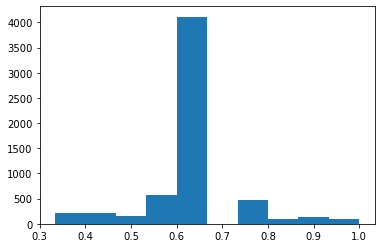

In [210]:
plt.hist(data_10)

In [205]:
plt.scatter(b.index, s=b.values, c=np.random.rand(10), alpha=0.5)

TypeError: scatter() missing 1 required positional argument: 'y'

<a id="6.Multi-Tokenize"></a>
# 6.Multi-Tokenize
<a href="#2.Table of Contents">Click this Link back to Top</a>

There are seveal ways we can let model to learn how to provide score in each judgement

- 1.TFIDF ( if using max_df and min_df, perhaps not fit seq2seq generation model)
- 2.Embedding
- 3.GLOVE
- 4.LDA

TFIDF not word2vect, it just cacualte a numerical value for each word and concatenate into sentence to build a matrix

In [25]:
class TfidfData(object):
    """
    """
    def __init__(self):
        """
        initial hyperparameters
        """
        # build a vocabulary that only consider the top max_features ordered by term frequency across the corpus. learned from EDA
        self.MAX_WORD = 13332
        
    def tfidf(df, vectorizer=None, to_cat= True):
        """
        Becuase we have to mentain 
        the relationship between corpus and his lable, we have several times list to DataFrame processes.
        I didn't show EDA part for setting up 

        Parameters:
        ------------
        df:pandas.DataFrame
            DataFrame, contain ['AUTHOR'] and ['CLASSIFY']. This is raw data.

        vectorizer:cofig
            When we apply to 

        Return:
        -------
        X_vector:array
            Dimension = (cleaned example, MAX_WORD).Cleaned data and transformed to TFIDF format 
            with original sequence, which means can be matched withcooresponding y_labels.

        y_vector:
            Dimension = (no. cleaned examples, NUM_LABELS)=(9630,3)


        """
        print("*"*50,"Start TFIDF transfrom", "*"*50)
        start_time = time.time()

         #*****************************cut down Part of optimization******************************************
    #     #we can't directly drop column because index will dynamicly decrease, but we can gather index of drop
    #     index_drop=[]
    #     #iteration through all DataFrame
    #     for i in range(len(df)):
    #         #according to plot and statitc result,>600 have 2628, <60 have 3540, so we only need 60<data<600
    #         if len(df.iloc[i,0])<60 or len(df.iloc[i,0])>600:
    #             #delete too big and too small
    #             index_drop.append(i)
    #     print(f"before drop shape={df.shape}")

    #     #drop row by list but remain old index number
    #     df = df.drop(index_drop,axis=0)
    #     print(f"after drop shape={df.shape}")
    #     #re.finall(\w+)  
    #     #*****************************cut down Part of optimization******************************************

        # inintial we need use vectorizer from train to process test data
        if vectorizer == None:
            vectorizer = TfidfVectorizer(sMAX_WORD='english', max_features = MAX_WORD)
            #when we built a vect, we need to import all words as corpus combination to generate a TFIDF dictornary
            vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
            #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
            data_2 = vect.transform(df['AUTHOR']).toarray()
            X_vector = np.array(data_2)
        else:
            vect = vectorizer.fit([" ".join(df['AUTHOR'].tolist())])
            #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
            X_vector = vect.transform(df['AUTHOR']).toarray()

        if to_categorical == True:
            #To remain the relation between AUTHOR vector and CLASSIFY labels, we also output y_vector coorespondingly
            y_vector = to_categorical(np.array(df['CLASSIFY']))
        else:
            y_vector = df['CLASSIFY']

        cost_time = round((time.time()- start_time),4)
        print("*"*40,"End tfidf() with {} second".format(cost_time), "*"*40, end='\n\n')

        return df, X_vector, y_vector, vect

Is that more robust if i divide 13332 for every value in vector dataset?

In [171]:
# chatbot
# BLUE Rougue

In [7]:
# y_label_df.head(5)

<a id="6.8 Split Data"></a>
### 6.8 Split Data
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [26]:
def SplitData(X_vector,y_vector, test_size=0.2):
    """
    this is only for padded data split
    """
    print("*"*50,"Start train_test_split", "*"*50)
    start_time = time.time()
    X_train, X_val, y_train, y_val = train_test_split(X_vector, y_vector,
                                                        test_size=0.2, random_state=37)
    
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 37)
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End embedding() with {} seconds".format(cost_time), "*"*40, end='\n\n')
    return X_train, X_val, y_train, y_val

In [11]:
# X_train, X_test, X_val, y_train, y_test, y_val = split_data(question_padded,y_label_df, test_size=0.2)

In [12]:
# y_train.shape

<a id="7.Classify"></a>
# 7.Classify
<a href="#2.Table of Contents">Click this Link back to Top</a>

I will provide more than three type of input. All matrix will use number represent a whole sentence. What we can do include surpivsed learning to classify (NN, KNN) and unsurprivised learning to cluster (k-means + PCA)

<a id="7.1 KNN"></a>
### 7.1 KNN
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="7.2 Neural Network Classify"></a>
### 7.2 Neural Network Classify
<a href="#2.Table of Contents">Click this Link back to Top</a>

tranform category to one-hot, last layer use softmax, use argmax() to get predict result

<a id="7.3 K-means cluster + PCA"></a>
### 7.3 K-means cluster + PCA
<a href="#2.Table of Contents">Click this Link back to Top</a>

Get high dimentsion cluster result and reduce dimenstion to get a 3D/2D visulization result

<a id="8.Models"></a>
# 8.Models
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="8.1 Basic Neural Network"></a>
# 8.1 Basic Neural Network
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [345]:
def nn_model(word_index, MAX_SEQ_LEN):
    """
    Input is just padded question sequence, add Embedding layer transorfrom it into word vector and build up a sentence
    """
    #*************Hyperparameters************
    #max sequence/sentence length
    MAX_SEQ_LEN = MAX_SEQ_LEN
    MAX_Q_SEQ_LEN = 400
    MAX_A_SEQ_LEN = 1000
    # what is the word dimentsion for a single, for examplee, "thank" will have 
    EMBEDDING_DIM = 100
    #*************Hyperparameters************
    model = None
    
    
    input_layer_1 = Input(shape=(MAX_SEQ_LEN,), dtype='float32')
    embed_layer_2 = Embedding(input_dim = len(word_index) + 1,
                              output_dim = EMBEDDING_DIM,
                              input_length=MAX_SEQ_LEN
                              )(input_layer_1)
    pooling_layer_3 = GlobalAveragePooling1D()(embed_layer_2)
    dense_layer_4 = Dense(units = 32, activation='relu')(pooling_layer_3)
    output_layer_5 = Dense(units = 10, activation = 'softmax')(dense_layer_4)
    model = Model(inputs = input_layer_1, outputs = output_layer_5, name='nn_model')
    model.summary()
    return model
    

In [160]:
# nn_model(word_index)

1.CNN(u-gim, bi, trigum = contcant)
2.CNN 
3.GRU
4.BERT

<a id="8.2 LSTM"></a>
# 8.2 LSTM
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="8.3 n-gram CNN"></a>
# 8.3 n-gram CNN
<a href="#2.Table of Contents">Click this Link back to Top</a>

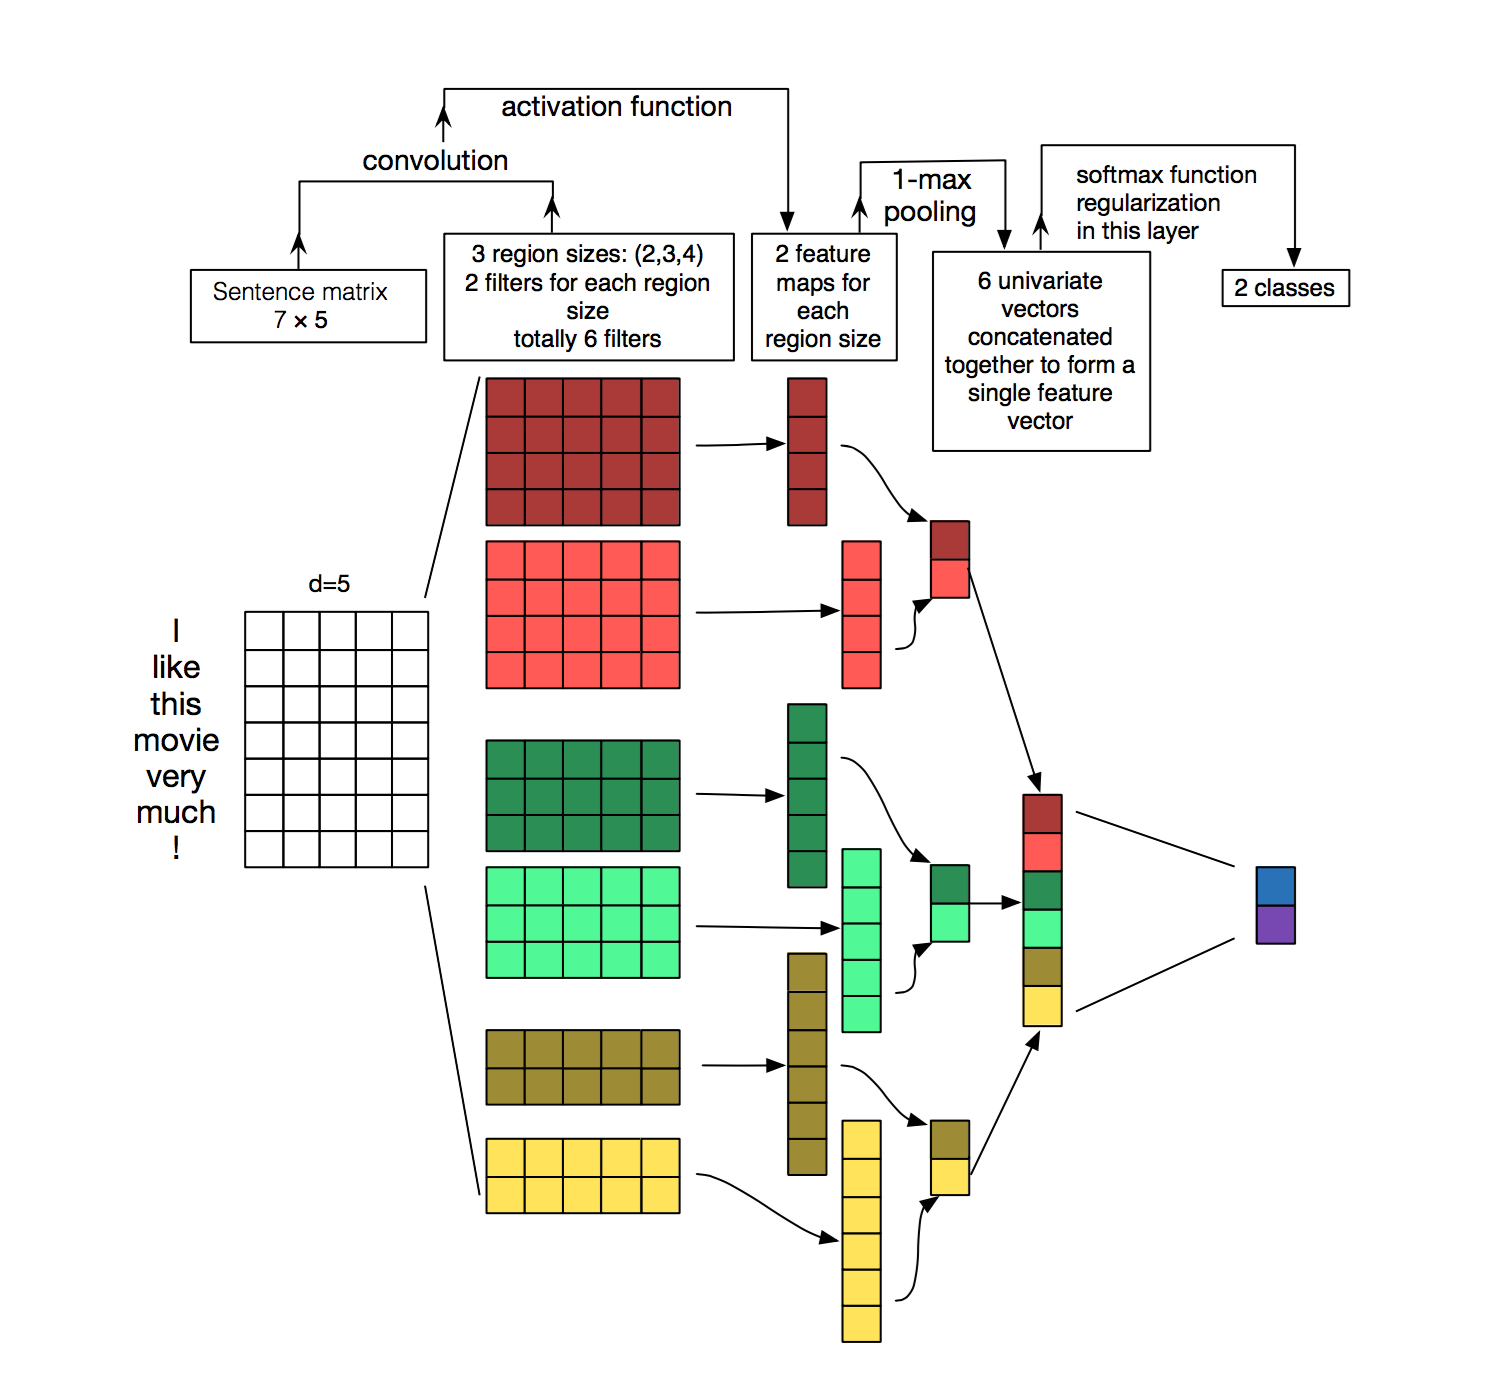

In [5]:
Image(filename = '04_images/18_CNN Architecture for sentence classification.png')

<a id="8.4 BERT"></a>
# 8.4 BERT
<a href="#2.Table of Contents">Click this Link back to Top</a>

<a id="8.5 Seq2Seq"></a>
# 8.5 Seq2Seq
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [359]:
def compile_fit(model_input, X_train, X_val, y_train, y_val, loss_fun, epoch_num=3):
    """
    """
    start_time = time.time()
    print("*"*40,"Start {} Processing".format(model_input._name), "*"*40)
    
    model = model_input
#     METRICS = [
#           metrics.TruePositives(name='tp'),
#           metrics.FalsePositives(name='fp'),
#           metrics.TrueNegatives(name='tn'),
#           metrics.FalseNegatives(name='fn'), 
#           metrics.CategoricalAccuracy(name='accuracy'),
#           metrics.Precision(name='precision'),
#           metrics.Recall(name='recall'),
#           metrics.AUC(name='auc'),
#           F1Score(num_classes = int(y_train.shape[1]), name='F1')
#     ]

    learning_rate = 1e-2
    opt_adam = optimizers.Adam(lr = learning_rate, decay=1e-5)
    model.compile(loss=loss_fun,
                  optimizer=opt_adam,
                  metrics = ['accuracy'])
    # batch_size is subjected to my GPU and GPU memory, after testing, 32 is reasonable value size. 
    # If vector bigger, this value should dercrease
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epoch_num, batch_size=32, verbose =1)
    # dic = ['loss', 'accuracy', 'val_loss','val_accuracy']
    history_dict = [x for x in history.history]
    # model.predict(train_features[:10])

#     print("*"*50)
#     x_axis = list(range(epoch_num))
#     # loss
#     plt.plot(x_axis, history.history[history_dict[0]], color = 'r', lw = 2, label = history_dict[0])
#     # val_loss
#     plt.plot(x_axis, history.history[history_dict[10]], color = 'y', lw = 2, label = history_dict[10])
#     # accuracy
#     plt.plot(x_axis, history.history[history_dict[5]], color = 'b', lw = 2, label = history_dict[5])
#     # validataion_accuracy
#     plt.plot(x_axis, history.history[history_dict[15]], color = 'k', lw = 2, label = history_dict[15])
#     plt.title(model_input._name)
#     plt.legend()
#     plt.xlabel('Epochs')
#     # plt.ylabel(str(dic[i]))
#     plt.show()
    
    cost_time = round((time.time()- start_time),4)
    print("*"*40,"End {} with {} seconds".format(model_input._name, cost_time), "*"*40, end='\n\n')
    return history, model

In [116]:
# X_train.shape

(4863, 300)

In [161]:
# history, model_2 = compile_fit(nn_model(), X_train, X_test, X_val, y_train, y_test, y_val, loss_fun = 'binary_crossentropy', epoch_num=50)
# history, model_2 = compile_fit(nn_model(word_index), X_train, X_val, y_train, y_val, loss_fun = 'mse', epoch_num=10)

<a id="9.Main Function"></a>
# 9.Main Function
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [360]:
def main():
    """
    We use this function to call process one by one.
    """
    pre = PreprocessData()
    df_q_train_raw, X_question_df, X_answer_df, y_question_df, y_answer_df = pre.import_data("03_data/02_train.csv")
#     df_test_raw, X_q_test_df, X_a_test_df, y_q_test_df, y_a_test_df = pre.import_data("03_data/03_test.csv")

    clean = CleanData()
    question_cleaned_df = clean.clean_process(X_question_df, column_1 ='question')
    answer_cleaned_df = clean.clean_process(X_answer_df, column_1='answer')
#     q_test_cleaned_df = clean.clean_process(X_q_test_df, column_1 ='question')
#     a_test_cleaned_df = clean.clean_process(X_a_test_df, column_1='answer')
    
    eda_class = EdaData()
    # eda_class.question_plot(y_question_df)
    # question_padded have shape (6079,100) can be used in fewer embedding
    
    token_class = TokenizeData()
    # do not use '|', insteand we can use comma to next line and bracket to state they are together
    (question_padded, question_cleaned_df, answer_padded ,word_index, 
     index_word) = token_class.tokenize_plot(question_cleaned_df, answer_cleaned_df)
    # get question label
#     y_q_label_df, y_a_label_df = token_class.label_feature(y_question_df, y_answer_df)


    # ********Using manuually categorical*************
    label_class = LabelProcess(y_question_df, y_answer_df)
    y_a_label_df = label_class.manual_calssify(y_answer_df.iloc[:,0])

#     q_test_padded, q_test_cleaned_df = eda_class.tokenize_plot(q_test_cleaned_df, a_test_cleaned_df)
#     # get question label
#     y_label_test_df = eda_class.label_feature(y_q_test_df)
    
    # question part and answer part will be seperately split
    X_q_train, X_q_val, y_q_train, y_q_val = SplitData(question_padded, y_q_label_df, test_size=0.2)
    X_a_train, X_a_val, y_a_train, y_a_val = SplitData(answer_padded, y_a_label_df, test_size=0.2)
    
#     history, model_2 = compile_fit(nn_model(word_index), X_q_train, X_q_val, y_q_train, y_q_val, loss_fun = 'mse', epoch_num=1)
    history_a, model_a = compile_fit(nn_model(word_index, MAX_SEQ_LEN = 1000), 
                                     X_a_train, X_a_val, y_a_train, y_a_val, loss_fun = 'categorical_crossentropy', epoch_num=3)
    
    return (X_question_df, X_answer_df, y_question_df, y_answer_df, 
            question_padded, question_cleaned_df, answer_cleaned_df, y_q_label_df, y_a_label_df,
            X_a_train, X_a_val, y_a_train, y_a_val, history_a,model_a, word_index)

In [361]:
if __name__=="__main__":
    (X_question_df, X_answer_df, y_question_df, y_answer_df, 
            question_padded, question_cleaned_df, answer_cleaned_df, y_q_label_df, y_a_label_df,
            X_a_train, X_a_val, y_a_train, y_a_val, history_a,model_a, word_index) = main()

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.2095 second ****************************************

************************************************** Start Clean data **************************************************
**************************************** End clean_data() with 3.2103 second ****************************************

we got unique 72070 words
we have 13332 words appear more than 5 times
************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.008 seconds ****************************************

************************************************** Start train_test_split **************************************************
**************************************** End embedding() with 0.014 seconds *********

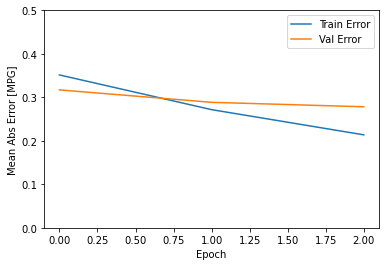

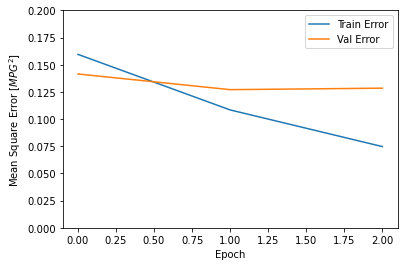

In [134]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.2])
  plt.legend()
  plt.show()


plot_history(history_a)

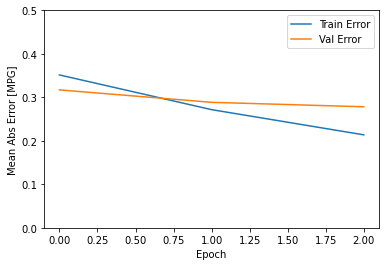

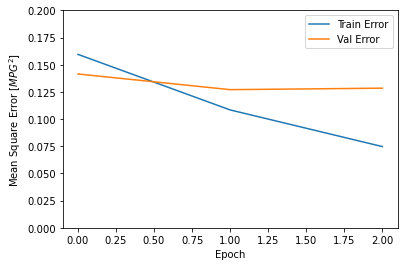

In [134]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.2])
  plt.legend()
  plt.show()


plot_history(history_a)

In [135]:
loss, mae, mse = model_2.evaluate(X_val, y_val, verbose=1)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

1216/1216 [==============================] - ETA: 0s - loss: 0.0494 - mae: 0.1642 - mse: 0.049 - 0s 170us/sample - loss: 0.0492 - mae: 0.1645 - mse: 0.0492
Testing set Mean Abs Error:  0.16


In [156]:
test_2 = model_2.predict(X_val)

In [134]:
len(test_2[:,0])

1216

In [135]:
len(y_val.iloc[:,0])

1216

In [141]:
type(list(y_val.iloc[:,0]))

list

In [103]:
len(test_predictions[:,1])

1216

In [93]:
y_val.head(5)

,question_asker_intent_understanding,question_body_critical,question_expect_short_answer,question_interestingness_others
1904,0.500000,0.666667,1.0,0.666667
4922,1.000000,0.888889,1.0,0.777778
5138,0.888889,0.444444,0.5,0.333333
463,1.000000,0.666667,0.0,0.666667
2487,0.333333,1.000000,1.0,0.666667


In [136]:
test_predictions[:,0][0:10]

array([0.9165735 , 0.98398495, 0.8833388 , 0.89474607, 0.9236015 ,
       0.8738643 , 0.86842227, 0.80014217, 0.7406287 , 0.68903804],
      dtype=float32)

In [148]:
y_val.iloc[:,1].values.flatten()

array([0.66666667, 0.88888889, 0.44444444, ..., 1.        , 0.55555556,
       1.        ])

In [142]:
test_predictions

array([[0.9165735 , 0.51900846, 0.3917757 , 0.5801662 ],
       [0.98398495, 0.86939836, 0.83998144, 0.7883672 ],
       [0.8833388 , 0.6793381 , 0.5259119 , 0.61195445],
       ...,
       [0.93713665, 0.6890639 , 0.63639784, 0.64063716],
       [0.85376287, 0.5666379 , 0.46438912, 0.57637465],
       [1.0403752 , 0.9113041 , 0.19819868, 0.7242764 ]], dtype=float32)

In [144]:
COL_NUM = 1

In [146]:
x_axis = np.array(y_val.iloc[:,COL_NUM])
x_axis

array([0.66666667, 0.88888889, 0.44444444, ..., 1.        , 0.55555556,
       1.        ])

<function matplotlib.pyplot.show(close=None, block=None)>

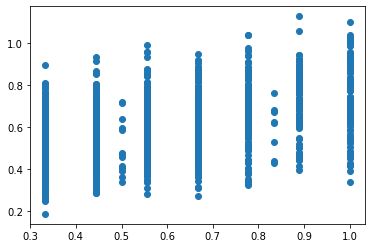

In [149]:
plt.scatter(x=x_axis, y = test_predictions[:,COL_NUM])
plt.show

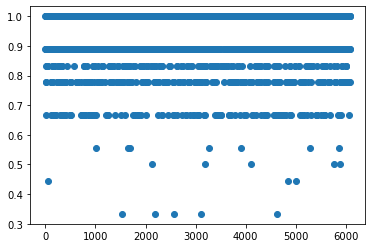

In [141]:
# from the plot we can see
plt.scatter(y_answer_df.index, y_answer_df.iloc[:,3])
plt.
plt.show()

In [153]:
test_predictions[:,1][0:10]

array([0.51900846, 0.86939836, 0.6793381 , 0.6349799 , 0.71984905,
       0.64740556, 0.81444615, 0.46530396, 0.46798593, 0.80635405],
      dtype=float32)

In [154]:
y_val.iloc[:,1].values.flatten()[0:10]

array([0.66666667, 0.88888889, 0.44444444, 0.66666667, 1.        ,
       0.44444444, 0.55555556, 0.44444444, 0.33333333, 0.44444444])

In [164]:
X_answer_df

,qa_id,answer,category,host,cleaned
0,0,"I just got extension tubes, so here's the skin...",LIFE_ARTS,photo.stackexchange.com,just got extension tubes so heres the skinny w...
1,1,It might be helpful to look into the definitio...,CULTURE,rpg.stackexchange.com,it might be helpful to look into the definitio...
2,2,Do you even need grooves? We make several pro...,SCIENCE,electronics.stackexchange.com,do you even need grooves we make several produ...
3,3,"Sending an ""affidavit"" it is a dispute between...",CULTURE,judaism.stackexchange.com,sending an affidavit it is dispute between ras...
4,5,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,graphicdesign.stackexchange.com,check out image trace in adobe illustrator lik...
...,...,...,...,...,...
6074,9642,If you're thinking about wearing a ski helmet ...,CULTURE,bicycles.stackexchange.com,if youre thinking about wearing ski helmet for...
6075,9643,\nYou can replace the pads (as stated elsewher...,CULTURE,bicycles.stackexchange.com,you can replace the pads as stated elsewhere t...
6076,9645,Maybe help if can be fixes origin of this erro...,TECHNOLOGY,unix.stackexchange.com,maybe help if can be fixes origin of this erro...
6077,9646,"As a non-mathematician, I am somewhat mystifie...",SCIENCE,mathoverflow.net,as nonmathematician am somewhat mystified by t...


In [96]:
y_val


,question_asker_intent_understanding,question_body_critical,question_expect_short_answer,question_interestingness_others
1904,0.500000,0.666667,1.000000,0.666667
4922,1.000000,0.888889,1.000000,0.777778
5138,0.888889,0.444444,0.500000,0.333333
463,1.000000,0.666667,0.000000,0.666667
2487,0.333333,1.000000,1.000000,0.666667
...,...,...,...,...
2637,1.000000,0.333333,0.666667,1.000000
4305,0.888889,1.000000,1.000000,0.666667
2779,1.000000,1.000000,1.000000,0.333333
2894,1.000000,0.555556,0.666667,0.555556


In [111]:
y_a_val.head(2)

,answer_satisfaction
1904,0.600000
4922,0.733333


In [113]:
test_predictions = model_3.predict(X_a_val)
test_predictions

array([[0.76603633],
       [0.7481627 ],
       [0.83968246],
       ...,
       [0.82251316],
       [0.71941155],
       [0.7509936 ]], dtype=float32)

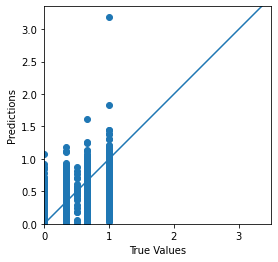

In [137]:
# LIST_INFO = [1,3,4, 5,7]
test_predictions = model_3.predict(X_a_val)

plt.scatter(x = y_a_val, y = test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [124]:
def get_scores(y_true, y_pred):
    """
    Argus:
    -----
    y_true:np.ndarray
    y_true:np.ndarray
    """
    # if they have same size, nothing happen,
    assert y_true.shape == y_pred.shape
#     assert y_true.shape[1] == num_targets
    # create empty dictionary
    scores = {}
    for target_name, i in 
    
    
    
    

In [136]:
scores_2 = stats.spearmanr(y_a_val, test_predictions)
scores_2

SpearmanrResult(correlation=0.034818079025034844, pvalue=0.22502772403359372)

In [125]:
get_scores(y_a_val, test_predictions)

AssertionError: 

ValueError: x and y must be the same size

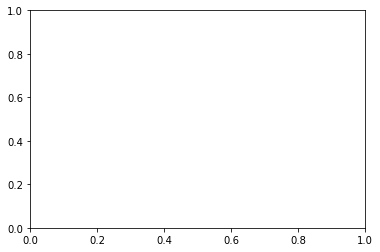

In [93]:
# LIST_INFO = [1,3,4, 5,7]
test_predictions = model_3.predict(X_a_val)

plt.scatter(x = y_val.iloc[:,1].values.flatten(), y = test_predictions[:,1].flatten()[LIST_INFO])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


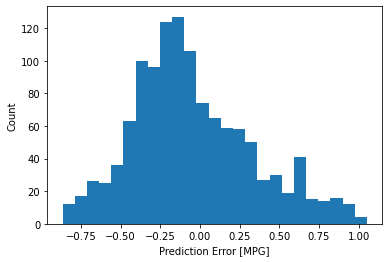

In [89]:
error = test_predictions[:,2].flatten() - y_val.iloc[:,2].values.flatten()
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [159]:
X_train

array([[  115,   433,   400, ...,     0,     0,     0],
       [12073,     8,     1, ...,     0,     0,     0],
       [  780,   407,  1193, ...,     0,     0,     0],
       ...,
       [   34,     3,   354, ...,     0,     0,     0],
       [   21,  2153,   204, ...,     0,     0,     0],
       [ 3589,   393,  1795, ...,     0,     0,     0]])

In [1]:
y_label_df.loc[:,0]

NameError: name 'y_label_df' is not defined

<a id="10.Unused Code"></a>
# 10.Unused Code
<a href="#1.Summary">Click this Link back to Top</a>

1.using question_user_page as benchmark, split quetsion_title or question_body into train_test, we believe different website have different type questions, so we can make evaluate and predict model

2.Using unsupervise learning to cluster question into differnt type, culster is depending on data preprocessing granularity. smaller grandularity, more spase cluster

3.After i embedding these sentence, you can use KNN SVM to do unsuperviese cluster

4.Using categore to cluster by CNN(n-gram / Glove / miniGPT）

5.Generage numerical value by former data and compart to anser_well_written

6.extract the root url like photo.stackchange.com to try to classfiy it with some argothrim, same question is to catgory column

7.If the result is not good enough, try to use url to grab more data to analysis

8.The data for this competition includes questions and answers from various StackExchange properties. Your task is to predict target values of 30 labels for each question-answer pair.

The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

9.for each dataframe maybe we need add category, and that will imporove performance

10.Stopword is meaningful for answer sequence, and so as punctuation. Try to only eliminate useless punctuatinon like '\`' but remain '?'and '!'
11.embedding is random initial word vector, but we can use Glove to import pretrain to impove performance

12.evalution part try to use BLEU score 

- https://www.tensorflow.org/tutorials/text/word_embeddings?hl=zh-cn
- https://towardsdatascience.com/nlp-building-a-question-answering-model-ed0529a68c54